In [1]:
import pandas as pd
import numpy as np
import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns

import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid

### 1. Load Data
---

In [5]:
data_df = pd.read_csv("data/Dataset.csv").iloc[:,:88].set_index("Code ID")
treatment_df = pd.read_csv("data/Treatments.csv").set_index("Code ID")

# Errors in input
# 2006097 - Cardiopulmonary symptom onset = 0026-01-01
# 2009206 - Cardiopulmonary symptom onset = 0001-01-01

samples_to_remove = [2006097, 2009206]

data_df = data_df.drop(samples_to_remove)

# Fix Dates
data_df = pd.concat([pd.to_datetime(data_df[amyloid.dates][var], format="mixed") for var in amyloid.dates], axis=1, keys=amyloid.dates).join(
    data_df.drop(amyloid.dates, axis=1)  
)

In [6]:
# Add encoding variables
data_df['Amyloid type'] = data_df['Sex'].apply(lambda x: utils.map_encoding(x, amyloid.enc_amyloid_type))
data_df['Sex'] = data_df['Sex'].apply(lambda x: utils.map_encoding(x, amyloid.enc_sex))
data_df['Ethnicity'] = data_df['Ethnicity'].apply(lambda x: utils.map_encoding(x, amyloid.enc_ethnicity))
data_df['Race'] = data_df['Race'].apply(lambda x: utils.map_encoding(x, amyloid.enc_race))
data_df['Education'] = data_df['Education'].apply(lambda x: utils.map_encoding(x, amyloid.enc_education))
data_df['Abdominal fat pad CR staining'] = data_df['Abdominal fat pad CR staining'].apply(lambda x: utils.map_encoding(x, amyloid.enc_staining))
data_df['Bone marrow CR staining'] = data_df['Bone marrow CR staining'].apply(lambda x: utils.map_encoding(x, amyloid.enc_staining))

for var in amyloid.amyloid_ros:
    data_df[var] = data_df[var].apply(lambda x: utils.map_encoding(x, amyloid.enc_ros))

data_df['Primary organ'] = data_df[var].apply(lambda x: utils.map_encoding(x, amyloid.enc_organ))
data_df['Secondary organ'] = data_df[var].apply(lambda x: utils.map_encoding(x, amyloid.enc_organ))

for var in amyloid.amyloid_symptoms:
    data_df[var] = data_df[var].apply(lambda x: utils.map_encoding(x, amyloid.enc_descriptors))

data_df["SIFE M-component"] = data_df[var].apply(lambda x: utils.map_encoding(x, amyloid.enc_m_components))
data_df["UIFE M-component"] = data_df[var].apply(lambda x: utils.map_encoding(x, amyloid.enc_m_components))

data_df["Mayo  2004 cardiac biomarker staging"] = data_df[var].apply(lambda x: utils.map_encoding(x, amyloid.enc_mayo_2004))
data_df["BU (BNP-based) cardiac staging"] = data_df[var].apply(lambda x: utils.map_encoding(x, amyloid.enc_bu_2019))

In [15]:
amyloid.dates

['Date of admission to center',
 'Date of birth',
 'Date of diagnosis',
 'Date of death',
 'Date of last visit',
 'Cardiopulmonary symptom onset',
 'Renal signs/symptom onset',
 'Neurologic symptom onset']

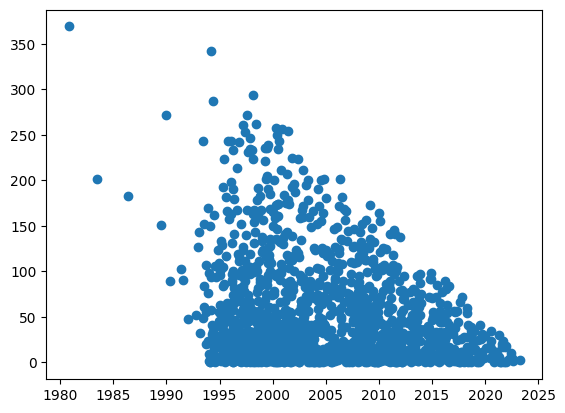

In [17]:
plt.scatter(data_df['Date of diagnosis'], data_df['Time to death from diagnosis (m)'])

<Axes: xlabel='Date of admission to center', ylabel='Count'>

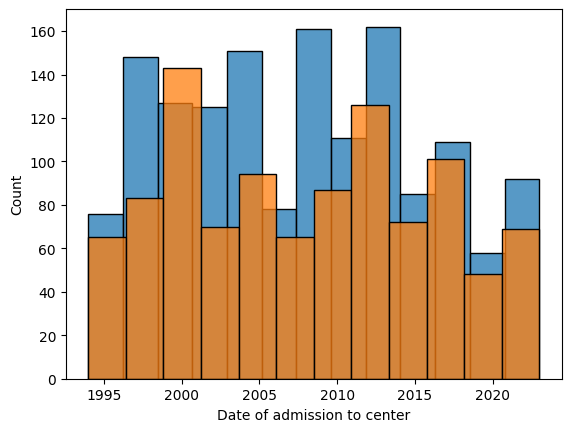

In [14]:
sns.histplot(data_df[data_df['Amyloid type']=='AL']['Date of admission to center'].dt.year)
sns.histplot(data_df[data_df['Amyloid type']=='MM_associated_AL']['Date of admission to center'].dt.year)

/var/folders/m0/69jv0yz94wd23rxxdwwkcn9w0000gp/T/ipykernel_63253/638143208.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_df['Date of admission to center'].dt.year)


<Axes: xlabel='Date of admission to center', ylabel='Density'>

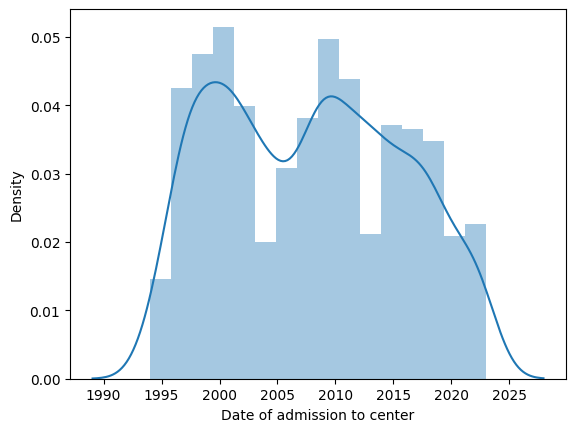

In [10]:
sns.distplot(data_df['Date of admission to center'].dt.year)

In [9]:
data_df.groupby("Amyloid type").size()


Amyloid type
AL                  1483
MM_associated_AL    1023
dtype: int64

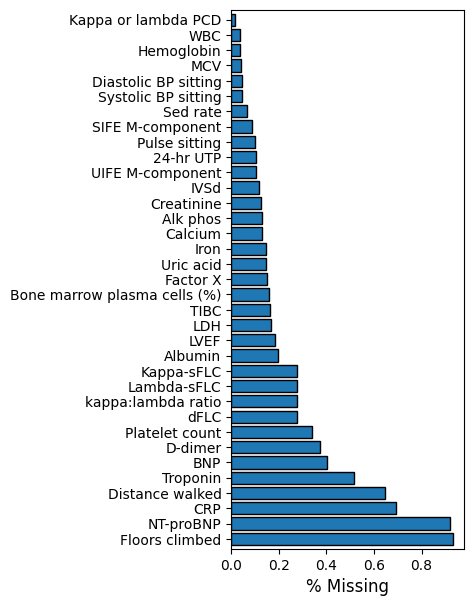

In [77]:
plot.missing_barplot(data_df[amyloid.qvars])

### 2. Imputation
---

In [62]:
from sklearn.impute import KNNImputer

# Median imputation
Xi_median = X.fillna(X.median())

# KNN Imputation
KNN_NEIGHBORS = 5

imputer = KNNImputer(n_neighbors=KNN_NEIGHBORS)

Xi_knn = pd.DataFrame(
    imputer.fit_transform(X), 
    index=X.index, 
    columns=X.columns
)

# TODO:
# - RF imputation
# - MICE

In [64]:
pd.DataFrame(X.mean(), index=X.columns, columns=['original']).join(
    pd.DataFrame(Xi_median.mean(), index=X.columns, columns=['median_imputed'])).join(
    pd.DataFrame(Xi_knn.mean(), index=X.columns, columns=['knn_imputed']))

,original,median_imputed,knn_imputed
Kappa-sFLC,131.101059,106.394080,161.053403
Lambda-sFLC,226.830379,191.228790,238.482027
kappa:lambda ratio,20.441756,16.077418,18.787477
dFLC,318.112152,268.414897,358.602027
IVSd,12.228461,12.206204,12.242377
LVEF,58.684238,58.887724,58.329227
WBC,7.877337,7.872040,7.871997
Hemoglobin,12.820141,12.819930,12.818663
MCV,91.536726,91.529926,91.525382
Sed rate,49.416180,49.208825,49.306422


In [86]:
Xi_knn.T

Code ID,6102,9338,9413,9419,9421,9422,9423,9429,9431,9432,...,2023163,2023166,2023168,2023173,2023174,2023177,2023181,2023188,2023191,2023193
Kappa-sFLC,14.00,41.96,392.700,45.920,31.580,9.600,63.160,71.320,56.360,1619.740,...,19.60,15.30,19.60,2484.60,54.30,17.40,21.10,1576.40,14.50,18.40
Lambda-sFLC,20.80,90.54,73.700,64.640,226.260,322.540,337.940,30.180,280.060,292.100,...,31.80,9.90,12.90,3.50,3.70,72.70,67.10,9.30,5.30,318.00
kappa:lambda ratio,0.67,2.17,57.764,2.374,2.002,0.086,2.186,4.776,2.554,49.684,...,0.62,1.55,1.52,709.89,14.68,0.24,0.31,169.51,2.74,0.06
dFLC,6.80,86.94,404.880,57.080,233.040,312.940,313.140,73.660,265.300,1885.360,...,12.20,-5.40,-6.70,2481.10,50.60,55.30,46.00,1567.10,9.20,299.60
IVSd,10.00,13.00,17.000,10.000,15.000,13.000,15.000,11.000,9.000,14.000,...,18.00,9.00,17.00,13.00,12.00,9.00,11.00,16.00,12.00,15.00
LVEF,57.00,60.60,52.400,64.400,59.200,56.000,60.400,69.400,30.000,50.800,...,70.00,63.00,57.00,50.00,63.00,70.00,68.00,53.00,50.00,65.00
WBC,7.80,7.50,9.500,6.600,15.400,3.900,9.100,10.100,5.700,6.900,...,5.30,7.70,6.10,12.00,2.40,5.90,5.40,8.20,3.20,4.70
Hemoglobin,16.30,13.70,14.000,12.900,16.600,13.500,8.500,12.100,13.500,11.800,...,13.30,11.40,10.70,10.50,12.00,15.00,13.60,9.80,11.40,12.90
MCV,87.00,95.00,96.000,91.000,96.000,89.000,77.000,91.000,92.000,99.000,...,88.00,102.00,87.00,97.00,101.00,103.00,102.00,99.00,90.00,95.00
Sed rate,8.00,77.00,12.000,86.000,33.400,32.000,63.000,41.200,55.000,126.000,...,36.00,55.00,117.00,28.00,81.00,62.00,32.00,128.00,21.00,44.00


In [89]:
P_df, pca, pca_vars = get_pcs(Xi_knn.T, return_vars=True)

In [104]:
pca.explained_variance_

array([0.28439821, 0.09081078, 0.03899374, 0.01860733, 0.01180861])

In [103]:
pca.__dir__()

['n_components',
 'copy',
 'whiten',
 'svd_solver',
 'tol',
 'iterated_power',
 'n_oversamples',
 'power_iteration_normalizer',
 'random_state',
 'feature_names_in_',
 'n_features_in_',
 '_fit_svd_solver',
 'mean_',
 'n_samples_',
 'components_',
 'n_components_',
 'explained_variance_',
 'explained_variance_ratio_',
 'singular_values_',
 'noise_variance_',
 '__module__',
 '__annotations__',
 '__doc__',
 '_parameter_constraints',
 '__init__',
 'n_features_',
 'fit',
 'fit_transform',
 '_fit',
 '_fit_full',
 '_fit_truncated',
 'score_samples',
 'score',
 '_more_tags',
 '_sklearn_auto_wrap_output_keys',
 '__abstractmethods__',
 '_abc_impl',
 'get_covariance',
 'get_precision',
 'transform',
 'inverse_transform',
 '_n_features_out',
 'get_feature_names_out',
 '__dict__',
 '__weakref__',
 '__new__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '_

In [102]:
pca.explained_variance_ratio_

array([0.61872634, 0.19756462, 0.08483336, 0.04048142, 0.02569038])

In [114]:
staging

['Mayo  2004 cardiac biomarker staging', 'BU (BNP-based) cardiac staging']

/var/folders/m0/69jv0yz94wd23rxxdwwkcn9w0000gp/T/ipykernel_9647/3553429679.py:176: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


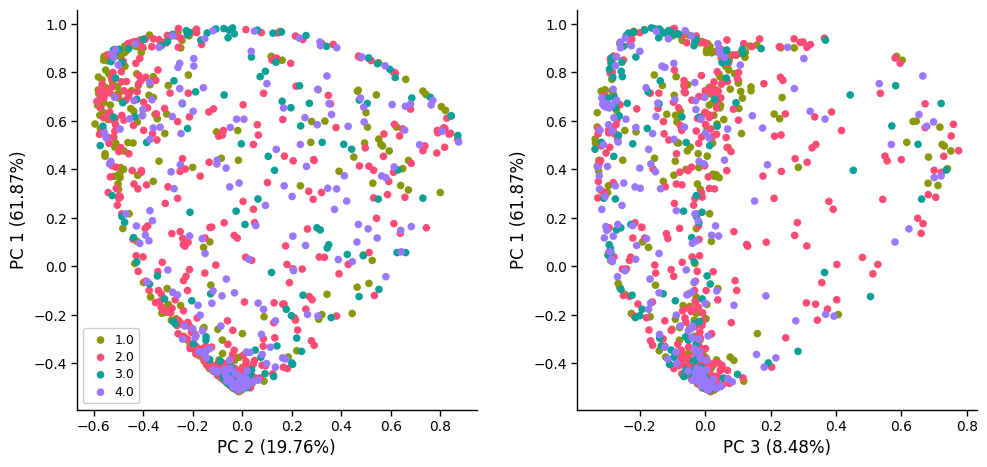

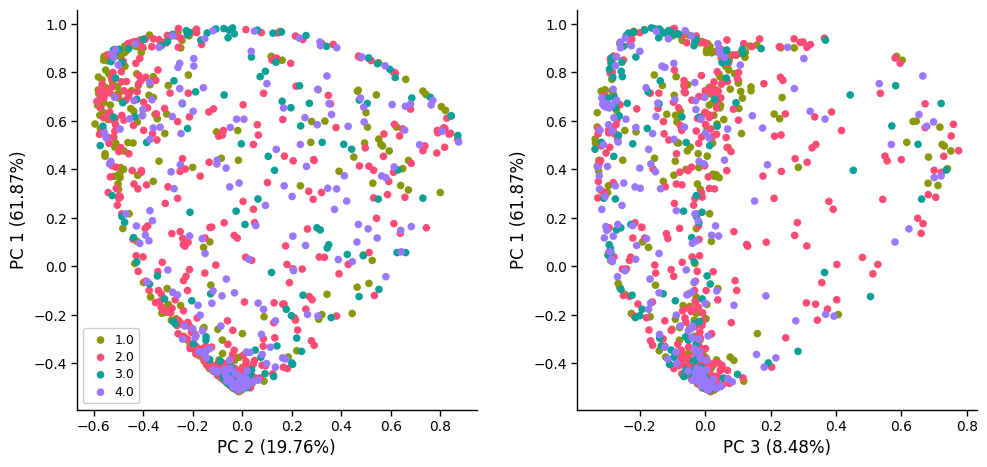

In [116]:
plot_pca(P_df, pca, cohort_s=data_df.loc[P_df.index, "BU (BNP-based) cardiac staging"].dropna())

In [79]:
P_df

,0,1,2,3,4
Code ID,,,,,
6102,-0.427365,-0.115625,-0.005098,-0.011187,0.014567
9338,0.940974,-0.275134,-0.001374,-0.160175,0.220697
9413,0.606091,0.268459,0.503314,-0.145485,-0.193285
9419,-0.510562,-0.015733,0.013816,0.016681,0.078276
9421,0.832954,-0.051338,-0.157550,-0.078484,-0.076221
...,...,...,...,...,...
2023177,-0.479706,-0.042307,-0.000752,0.004095,0.051617
2023181,-0.440461,-0.079774,-0.010062,-0.022429,0.019847
2023188,-0.350591,0.239394,0.283718,-0.049745,-0.086506


<Axes: >

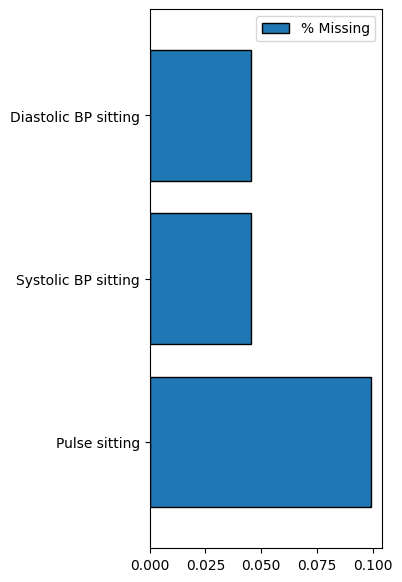

In [102]:
fig,ax = plt.subplots(figsize=(3,7))

pd.DataFrame(
    data_df[vitals].isna().sum().sort_values(ascending=False) / data_df.shape[0],
    columns=['% Missing']
).plot.barh(ax=ax, width=0.8, edgecolor='k')

In [41]:
data_df.columns

Index(['Amyloid type', 'Date of admission to center', 'Date of birth',
       'Date of diagnosis', 'Age at diagnosis (y)', 'Date of death',
       'Time to death from diagnosis (m)', 'Date of last visit', 'Sex',
       'Ethnicity', 'Race', 'Education', 'Abdominal fat pad CR staining',
       'Bone marrow CR staining', 'Kappa or lambda PCD', 'Kappa-sFLC',
       'Lambda-sFLC', 'kappa:lambda ratio', 'dFLC', 'Heart', 'Kidney', 'Liver',
       'GI Tract', 'Lung', 'Neurologic', '(Autonomic)', '(Peripheral)',
       'Soft tissue/MSK', 'Dermatologic', 'Primary organ', 'Secondary organ',
       'Cardiopulmonary symptom onset', 'Renal signs/symptom onset',
       'Neurologic symptom onset', 'Weight loss', 'Fatigue',
       'Exertional dyspnea', 'Dyspnea at rest', 'Orthopnea/PND',
       'Leg swelling (symptom)', 'Peripheral edema on exam', 'ascites symptom',
       'Ascites on exam', 'Orthostasis', 'Dizzy spells', 'Syncope',
       'Ecchymosis', 'Petechiae', 'Periorbital ecchymosis', 'Anorexia'

['9',
 'Daratumumab, pomalidomide, dex (DPd)\n10',
 'Venetoclax\n11',
 'Melphalan, IV/SCT\n12',
 'Melphalan, cyclic oral\n13',
 'Melphalan, daily oral\n14',
 'Melphalan, other\n15',
 'Decadron\n16',
 'Revlimid\n17',
 'Velcade\n18',
 'Thalidomide\n19',
 'Mini-Melphalan\n23',
 'Mel-Dex\n25',
 'Lenalidomide\n26',
 'Pomalidomide\n27',
 'Ixazomib\n28',
 'Daratumumab + other anti-CD38 therapy\n29',
 'Carfilzomib\n30',
 'Bendamustine\n31',
 'CyBorD\n32',
 'VMD\n37',
 'Vel/Mel/Dex\n39',
 'CyBorD daratumumab\n38',
 'Mel/Rev/Dex\n51',
 'CAPD (peritoneal dialysis)\n52',
 'Haemodialysis\n53',
 'Heart Transplant\n54',
 'Kidney Transplant\n55',
 'Liver Transplant\n56',
 'Pacemaker\n57',
 'Defibrillator\n99',
 'Other\n58',
 'Bendamustine + rituximab (R-benda)\n59',
 'cycloposhamide \n60',
 'Revlimid, velcade, dex\n61',
 'bortezomib, dex, rituximab\n62',
 'Other rituximab-based regimen\n63',
 'dara + IMiD\n64',
 'BTK inhibitor']